In [1]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [2]:
def preprocess(df):
    listBB = ['FaceRectX', 'FaceRectY', 'FaceRectWidth', 'FaceRectHeight']
    listLandmarks = ['x' + str(i) for i in range(68)] + ['y' + str(i) for i in range(68)]
    listTime = ['Frame', 'Timestamp']
    listDiff = ['AU1_diff','AU2_diff','AU4_diff','AU5_diff','AU6_diff','AU7_diff','AU9_diff','AU10_diff','AU11_diff',
                'AU12_diff','AU14_diff','AU15_diff','AU17_diff','AU20_diff','AU23_diff','AU24_diff','AU25_diff','AU26_diff','AU28_diff',
                'AU43_diff','anger_diff','disgust_diff','fear_diff','happiness_diff', 'sadness_diff','surprise_diff','neutral_diff','emotion_mirroring_diff']
    df = df.drop(columns = listBB + listLandmarks + listTime + listDiff)
    df = df[df['Label'] != 'x']
    df = df[df['Label'] != 'skip']
    df['Label'] = df['Label'].replace({'n': 0, 'no': 0, 'y': 1, 'yes': 1})
    df = df.drop(columns=['pupil_direction', 'Person'])
    
    return df

In [3]:
filenames = [f"finaldata/{i}.csv" for i in range(1, 21)]  # ["1.csv", "2.csv", ..., "12.csv"]
dataframes = []

for filename in filenames:
    df = pd.read_csv(filename)
    preprocessed_df = preprocess(df)
    dataframes.append(preprocessed_df)
combined_df = pd.concat(dataframes, ignore_index=True)
X = combined_df.drop(columns=['Label'])
y = combined_df['Label']

In [89]:
y.value_counts()

1    130957
0     24030
Name: Label, dtype: int64

In [4]:
smote = SMOTE(random_state=42)
# for col in X.columns:
#     print(col, ' : ', X[col].dtype)
# print(X.isna().sum().sum())

In [5]:
## 2a. If preserving the temporal nature of the data is crucial:
train_size = int(0.8 * len(X))  # 80% train, 20% test
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

## 2b. If shuffling the data is not a problem:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
y[-5:]

154982    0
154983    0
154984    0
154985    0
154986    0
Name: Label, dtype: int64

In [7]:
X_train_filled = X_train.fillna(X_train.median())
X_test_filled = X_test.fillna(X_train.median())

In [10]:
smote = 0

if smote:
    print('SMOTE xgboost')
    X_train_smote, y_train_smote = smote.fit_resample(X_train_filled, y_train)
    scale_pos_weight = len(y_train_smote[y_train_smote == 0]) / len(y_train_smote[y_train_smote == 1])
    model = xgb.XGBClassifier(objective='binary:logistic', random_state=42, scale_pos_weight=scale_pos_weight)  # Adjust hyperparameters as needed
    model.fit(X_train_smote, y_train_smote)
else:
    scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
    print(f'REGULAR xgboost, scale_weight:{scale_pos_weight}')
    model = xgb.XGBClassifier(objective='binary:logistic', random_state=42, scale_pos_weight=0.005)  # Adjust hyperparameters as needed
    model.fit(X_train, y_train)


REGULAR xgboost, scale_weight:0.16375701601246456


In [11]:
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

Accuracy: 71.24%
              precision    recall  f1-score   support

           0       0.24      0.17      0.20      6583
           1       0.79      0.86      0.82     24415

    accuracy                           0.71     30998
   macro avg       0.52      0.51      0.51     30998
weighted avg       0.68      0.71      0.69     30998

Confusion Matrix:
[[ 1096  5487]
 [ 3428 20987]]


Accuracy: 71.24%
              precision    recall  f1-score   support

           0       0.24      0.17      0.20      6583
           1       0.79      0.86      0.82     24415

    accuracy                           0.71     30998
   macro avg       0.52      0.51      0.51     30998
weighted avg       0.68      0.71      0.69     30998



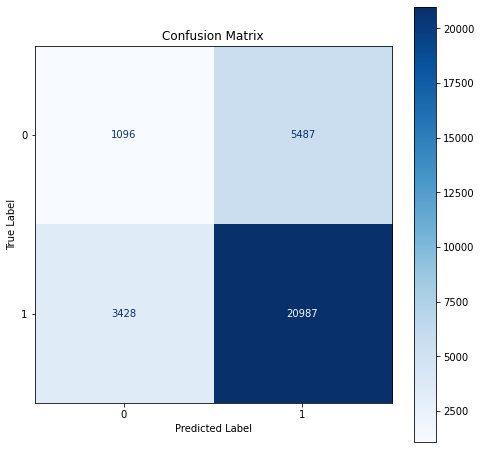

In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print(classification_report(y_test, y_pred))

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(ax=ax, cmap=plt.cm.Blues)

plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [49]:
y_test.value_counts()

1    16593
0      890
Name: Label, dtype: int64

In [11]:
y_test.value_counts()

1    16593
0      890
Name: Label, dtype: int64

In [12]:
y_train.value_counts()

1    59761
0    10170
Name: Label, dtype: int64

In [13]:
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100],
    'max_depth': [3],
    'min_child_weight': [1],
    'gamma': [0.1],
    'subsample': [0.6],
    'colsample_bytree': [0.8],
}

# Create an XGBoost classifier with default parameters
xgb_classifier = xgb.XGBClassifier(objective='binary:logistic', random_state=42, n_jobs=-1)

# Define the scoring metric (F1-score)
scoring = make_scorer(f1_score)

grid_search = GridSearchCV(
    estimator=xgb_classifier,
    param_grid=param_grid,
    scoring=scoring,
    cv=2,  # You can use more folds if needed
    verbose=2,
    n_jobs=-1,
)

grid_search.fit(X_train_smote, y_train_smote)

# Get the best parameters and the corresponding best F1-score
best_params = grid_search.best_params_
best_f1_score = grid_search.best_score_

print("Best Parameters: ", best_params)
print("Best F1-score: ", best_f1_score)

# Train and evaluate the XGBoost model with the best parameters
best_xgb_model = xgb.XGBClassifier(objective='binary:logistic', random_state=42, **best_params)
best_xgb_model.fit(X_train_smote, y_train_smote)

y_pred = best_xgb_model.predict(X_test_filled)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print(classification_report(y_test, y_pred))

Fitting 2 folds for each of 6 candidates, totalling 12 fits
Best Parameters:  {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.2, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.6}
Best F1-score:  0.6609166673937559
Accuracy: 92.79%
              precision    recall  f1-score   support

           0       0.01      0.01      0.01       890
           1       0.95      0.98      0.96     16593

    accuracy                           0.93     17483
   macro avg       0.48      0.49      0.49     17483
weighted avg       0.90      0.93      0.91     17483



In [15]:
y_train.value_counts()

1    59761
0    10170
Name: Label, dtype: int64